In [1]:
# this version will take the dataset without index so see if this effects the momentum

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd

#load the consolidated dataset
df = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\data2.csv')

# remove extra rows and columns
df = df.iloc[200:5383, 0:62]

# reformat Local time variable as a datetime
from datetime import datetime

df['Date'] = df['Date'].str[6:10] +'-'+ df['Date'].str[3:5] +'-'+ df['Date'].str[0:2]
df['Date'] = pd.to_datetime(df['Date'])

df.shape[0]

C:\Users\alexm\AppData\Local\Temp\ipykernel_23960\3067084044.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\data2.csv')


5183

In [3]:
# normalise data

df_norm = df.iloc[:, 5:]
df_dates = df.iloc[:, :5]

for col in df_norm.columns:
    df_norm[col] = (df_norm[col] - df_norm[col].mean())/ df_norm[col].std()

x = df_norm.to_numpy()
y = df_dates.to_numpy()
cols = df.columns
z = np.append(y,x, axis=1)

df_norm2 = pd.DataFrame(z, columns=cols)

# add an integer series to replace date for use in the ANN
df_norm2['DateID'] = range(df_norm2.shape[0])
first_column = df_norm2.pop('DateID') 
df_norm2.insert(0, 'DateID', first_column)

df_norm2.iloc[:,2:] = df_norm2.iloc[:,2:].astype(float)

df_norm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5183 entries, 0 to 5182
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DateID           5183 non-null   int64         
 1   Date             5183 non-null   datetime64[ns]
 2   Day              5183 non-null   float64       
 3   Month            5183 non-null   float64       
 4   Year             5183 non-null   float64       
 5   Close_Mid        5183 non-null   float64       
 6   Volume_Bid       5183 non-null   float64       
 7   Volume_Ask       5183 non-null   float64       
 8   Volume_Tot       5183 non-null   float64       
 9   Close_Sprd       5183 non-null   float64       
 10  5D-MA            5183 non-null   float64       
 11  10D-MA           5183 non-null   float64       
 12  20D-MA           5183 non-null   float64       
 13  50D-MA           5183 non-null   float64       
 14  200D-MA          5183 non-null   float64

In [4]:
# first a function to generate an n-step timeseries from one feature

# i = length of time series, feat = name of column
def datats(i,feat):
    series = []
    data = df_norm2[feat]
    
    # create the dataset
    for j in range(len(data) - i +1):
        series.append(data[j:j+i])
    series = np.array(series)
    series = np.asfarray(series)
    
    # create the column names
    lst = []
    cols = np.array(lst)
    for k in range(i):
        cols = np.append(cols,feat+'-'+str(k))
    # generate the dataframe
    df_ts = pd.DataFrame(series, columns=cols)

    # add the date ID of the start of the timeseries for reference
    df_ts['DateID'] = df_norm2['DateID'][0:len(data) - i +1]
    # shift column 'C' to first position 
    first_column = df_ts.pop('DateID')
    # insert column using insert(position,column_name,first_column) function 
    df_ts.insert(0, 'DateID', first_column)
    
    return df_ts


In [5]:
# function test
x = datats(3,'Close_Mid')
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5181 entries, 0 to 5180
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateID       5181 non-null   int64  
 1   Close_Mid-0  5181 non-null   float64
 2   Close_Mid-1  5181 non-null   float64
 3   Close_Mid-2  5181 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 162.0 KB


In [390]:
# build a time series of m steps for the forecasted price, m+n steps for input features and n for output
# to do this we create all timeseries for each input/output as per the above and then inner join on DateID to get dates consistent

feats = ['Volume_Tot','Close_Sprd','US-BaseRate', 'UK-BaseRate','UK-5Y-Inf','US-2Y-Int',
                     'US-10Y-Int','UK-2Y-Int','UK-10Y-Int','US-RealGDP','US-Unemp', 'US-CPI','US-HousePrice',
                     'US-CommmRealEst','US-MktVol','UK-RealGDP','UK-CPI','UK-Unemp','UK-CorpProf',
                     'UK-HshldInc','UK-ResPropInc','UK-SecLend','UK-ConsCred','UK-RetailVol','UK-MktVol']
m = 750
n = 250

# The model inputs require the sample period m days of close mid and m+n days of the other features since these carry
# m days for the sample period and n days for the scenario
# The output is the n days of Close_Mid that we want to predict

ts_in = datats(m,'Close_Mid')

for k in range(len(feats)):
    temp = datats(m+n,feats[k])
    ts_in = ts_in.merge(temp, on='DateID')

ts_out = datats(n,'Close_Mid')
ts_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4184 entries, 0 to 4183
Columns: 25751 entries, DateID to UK-MktVol-999
dtypes: float64(25750), int64(1)
memory usage: 822.0 MB


In [391]:
# trim the datasets to match assuming n<m (i.e. output timeseries is smaller than input)
# note we need to reindex

# remove the first m time steps from the output
ts_out = ts_out.iloc[m:ts_out.shape[0],].reset_index()

# remove the last n timesteps from the input
ts_in = ts_in.iloc[0:ts_in.shape[0],].reset_index()

In [392]:
# align the dates of the 
print('input')
print(ts_in.shape)
print(ts_in['DateID'][0])
print(ts_in['DateID'][ts_in.shape[0]-1])

print('output')
print(ts_out.shape)
print(ts_out['DateID'][0])
print(ts_out['DateID'][ts_out.shape[0]-1])

ts_in.iloc[0,1:]

input
(4184, 25752)
0
4183
output
(4184, 252)
750
4933


DateID           0.000000
Close_Mid-0      1.860770
Close_Mid-1      1.867550
Close_Mid-2      1.890760
Close_Mid-3      1.892390
                   ...   
UK-MktVol-995    0.330573
UK-MktVol-996    0.330573
UK-MktVol-997    0.330573
UK-MktVol-998    0.330573
UK-MktVol-999    0.330573
Name: 0, Length: 25751, dtype: float64

In [393]:
# generate data for test/train
# exclude the index for inputs
X = ts_in.iloc[:,1:].values

# drop the Startdate and index for output
y = ts_out.iloc[:,2:].values

# check a value is as expected
#X[0,]
y[400,:]

array([1.976125, 1.969625, 1.983225, 1.977975, 1.988775, 1.995025,
       2.0059  , 1.99915 , 2.003725, 1.998725, 2.00335 , 1.9917  ,
       1.999475, 1.986825, 1.99165 , 1.99395 , 1.97895 , 1.98175 ,
       1.98415 , 1.975275, 1.9623  , 1.9547  , 1.9478  , 1.944025,
       1.921075, 1.9109  , 1.89685 , 1.8704  , 1.86985 , 1.8661  ,
       1.8652  , 1.867125, 1.862075, 1.878275, 1.8527  , 1.8533  ,
       1.840075, 1.8356  , 1.829475, 1.82105 , 1.80125 , 1.7839  ,
       1.776925, 1.7685  , 1.76635 , 1.75815 , 1.76055 , 1.752975,
       1.75795 , 1.79405 , 1.799525, 1.7837  , 1.81721 , 1.81815 ,
       1.83175 , 1.854525, 1.85235 , 1.846575, 1.83735 , 1.844475,
       1.808725, 1.780625, 1.7697  , 1.7639  , 1.7714  , 1.743975,
       1.74565 , 1.73055 , 1.709775, 1.704725, 1.7341  , 1.739575,
       1.726825, 1.730425, 1.728375, 1.715175, 1.67055 , 1.626325,
       1.622975, 1.590325, 1.55515 , 1.590825, 1.63725 , 1.645125,
       1.607825, 1.58195 , 1.595725, 1.590475, 1.562675, 1.564

In [394]:
# check the dataframes have what we need
print('input')
print(ts_in.iloc[:,1:].shape)
print(ts_in.iloc[:,1:]['DateID'][0])
print(ts_in.iloc[:,1:]['DateID'][ts_in.shape[0]-1])

print('output')
print(ts_out.iloc[:,2:].shape)
print(ts_out.iloc[:,1:]['DateID'][0]) # include col2 because this contains the ID of the start/end date
print(ts_out.iloc[:,1:]['DateID'][ts_out.shape[0]-1])

ts_out.iloc[:,2:].head()

input
(4184, 25751)
0
4183
output
(4184, 250)
750
4933


,Close_Mid-0,Close_Mid-1,Close_Mid-2,Close_Mid-3,Close_Mid-4,Close_Mid-5,Close_Mid-6,Close_Mid-7,Close_Mid-8,Close_Mid-9,...,Close_Mid-240,Close_Mid-241,Close_Mid-242,Close_Mid-243,Close_Mid-244,Close_Mid-245,Close_Mid-246,Close_Mid-247,Close_Mid-248,Close_Mid-249
0,1.97560,1.95355,1.95612,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,...,2.071100,2.068600,2.082325,2.06130,2.05598,2.065950,2.059200,2.026700,2.027850,2.029875
1,1.95355,1.95612,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,1.93768,...,2.068600,2.082325,2.061300,2.05598,2.06595,2.059200,2.026700,2.027850,2.029875,2.046200
2,1.95612,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,1.93768,1.93965,...,2.082325,2.061300,2.055980,2.06595,2.05920,2.026700,2.027850,2.029875,2.046200,2.034100
3,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,1.93768,1.93965,1.93202,...,2.061300,2.055980,2.065950,2.05920,2.02670,2.027850,2.029875,2.046200,2.034100,2.047100
4,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,1.93768,1.93965,1.93202,1.94508,...,2.055980,2.065950,2.059200,2.02670,2.02785,2.029875,2.046200,2.034100,2.047100,2.041400


In [395]:
print(X.shape)
print(y.shape)

(4184, 25751)
(4184, 250)


In [396]:
# Generate an adaptable fully connected neural net with the correct size of input/ouput layers from the above dataset
nodes = 500
slope = 0.3

model = nn.Sequential(nn.Linear(ts_in.iloc[:,1:].shape[1], nodes),nn.LeakyReLU(negative_slope=slope),
                      nn.Linear(nodes,nodes),nn.LeakyReLU(negative_slope=slope),
                      nn.Linear(nodes,nodes),nn.LeakyReLU(negative_slope=slope),
                      nn.Linear(nodes, ts_out.iloc[:,2:].shape[1]),nn.LeakyReLU(negative_slope=slope))

# Tanh, Sigmoid don't work very well since the range of the functions is limited to [-1,1] or [0,1]

# set parameters of the learning
criterion = nn.MSELoss()
epochs = 1000
rand_st = 42 # random state

# optimiser and learning rate
opt = torch.optim.Adam(model.parameters(), lr = 0.001)

# container for tests
results = np.empty((0, 5))


# train the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=rand_st)

# convert to tensor for use in pyTorch
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# seed a random number to replicate data
torch.manual_seed(rand_st)

# train the model and capture the time taken

import time
t_start = time.time()

for i in range(epochs):
    # create predictions
    y_pred = model(X_train)

    # calculate loss and add to the list
    loss = criterion(y_pred, y_train)

    # performs back propogation
    opt.zero_grad()
    loss.backward()
    opt.step()

t_stop = time.time()
process_time = round((t_stop - t_start), 2)
print(process_time)

# calculate a prediction
pred = model(torch.FloatTensor(X))


933.42


In [397]:
pred.shape

torch.Size([4184, 250])

In [398]:
pred

tensor([[1.9207, 1.9470, 1.9548,  ..., 2.0013, 2.0015, 2.0008],
        [1.9215, 1.9529, 1.9594,  ..., 2.0093, 2.0050, 2.0056],
        [1.9264, 1.9553, 1.9615,  ..., 2.0104, 2.0098, 2.0066],
        ...,
        [1.1870, 1.1797, 1.2099,  ..., 1.2564, 1.2749, 1.2572],
        [1.1750, 1.1819, 1.2018,  ..., 1.2454, 1.2733, 1.2500],
        [1.1608, 1.1836, 1.2021,  ..., 1.2359, 1.2792, 1.2369]],
       grad_fn=<LeakyReluBackward0>)

In [399]:
# calculate the MSE for this model
mse = nn.MSELoss()

# create a target tensor from the ts_out dataframe
target = torch.FloatTensor(ts_out.iloc[:,2:].values)
output = mse(pred, target)
print("MSE loss:", output.item())

MSE loss: 0.0002463526325300336


In [400]:
# visualise results
# convert tensors to dataframes

cols = ts_out.iloc[:,2:].columns
df_pred = pd.DataFrame(pred.detach().numpy(),columns=cols)
df_target = pd.DataFrame(target.detach().numpy(),columns=cols)

# attach correct start dates
df_pred['DateID'] = ts_out.iloc[:,1:2]
fc1 = df_pred.pop('DateID') # insert column using insert(position,column_name,first_column) function 
df_pred.insert(0, 'DateID', fc1)
df_pred['DateID'] = ts_out.iloc[:,1:2]

df_target['DateID'] = ts_out.iloc[:,1:2]
fc2 = df_target.pop('DateID') # insert column using insert(position,column_name,first_column) function 
df_target.insert(0, 'DateID', fc2)
df_target['DateID'] = ts_out.iloc[:,1:2]

df_pred.head()

,DateID,Close_Mid-0,Close_Mid-1,Close_Mid-2,Close_Mid-3,Close_Mid-4,Close_Mid-5,Close_Mid-6,Close_Mid-7,Close_Mid-8,...,Close_Mid-240,Close_Mid-241,Close_Mid-242,Close_Mid-243,Close_Mid-244,Close_Mid-245,Close_Mid-246,Close_Mid-247,Close_Mid-248,Close_Mid-249
0,750,1.920718,1.946962,1.954756,1.942556,1.958998,1.942258,1.958327,1.952651,1.958225,...,2.050831,2.046052,2.041870,2.044127,2.038309,2.009138,2.016716,2.001317,2.001459,2.000776
1,751,1.921500,1.952887,1.959424,1.944738,1.958723,1.944624,1.960925,1.954276,1.962366,...,2.051580,2.045823,2.043824,2.040954,2.037483,2.009603,2.018782,2.009306,2.004986,2.005650
2,752,1.926366,1.955300,1.961542,1.948072,1.960606,1.947187,1.959939,1.955276,1.962337,...,2.051892,2.043139,2.041011,2.036719,2.036379,2.010221,2.018975,2.010422,2.009809,2.006595
3,753,1.928069,1.955659,1.960420,1.945976,1.956760,1.946520,1.957362,1.954206,1.963796,...,2.048388,2.040154,2.039519,2.034666,2.034626,2.010292,2.019915,2.011497,2.014036,2.010362
4,754,1.931797,1.956633,1.960897,1.945550,1.953650,1.946545,1.956297,1.955891,1.962590,...,2.043796,2.037791,2.035550,2.030602,2.031595,2.014442,2.023105,2.011745,2.017968,2.011798


In [401]:
# generate the results in original format by taking a row of data and attaching correct dates

# attach start date to dataframe

df_pred2 = df_pred.merge(df_norm2.iloc[:,0:2], on='DateID')
df_pred2.head()
fc3 = df_pred2.pop('Date')
df_pred2.insert(1, 'Date', fc3)

df_target2 = df_target.merge(df_norm2.iloc[:,0:2], on='DateID')
df_target2.head()
fc3 = df_target2.pop('Date')
df_target2.insert(1, 'Date', fc3)

df_target2.head()

,DateID,Date,Close_Mid-0,Close_Mid-1,Close_Mid-2,Close_Mid-3,Close_Mid-4,Close_Mid-5,Close_Mid-6,Close_Mid-7,...,Close_Mid-240,Close_Mid-241,Close_Mid-242,Close_Mid-243,Close_Mid-244,Close_Mid-245,Close_Mid-246,Close_Mid-247,Close_Mid-248,Close_Mid-249
0,750,2006-12-24,1.97560,1.95355,1.95612,1.96297,1.95853,1.95894,1.97360,1.95123,...,2.071100,2.068600,2.082325,2.06130,2.05598,2.065950,2.059200,2.026700,2.027850,2.029875
1,751,2006-12-25,1.95355,1.95612,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,...,2.068600,2.082325,2.061300,2.05598,2.06595,2.059200,2.026700,2.027850,2.029875,2.046200
2,752,2006-12-26,1.95612,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,...,2.082325,2.061300,2.055980,2.06595,2.05920,2.026700,2.027850,2.029875,2.046200,2.034100
3,753,2006-12-27,1.96297,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,1.93768,...,2.061300,2.055980,2.065950,2.05920,2.02670,2.027850,2.029875,2.046200,2.034100,2.047100
4,754,2006-12-28,1.95853,1.95894,1.97360,1.95123,1.94274,1.92905,1.93768,1.93965,...,2.055980,2.065950,2.059200,2.02670,2.02785,2.029875,2.046200,2.034100,2.047100,2.041400


Text(0.5, 0, 'Date')

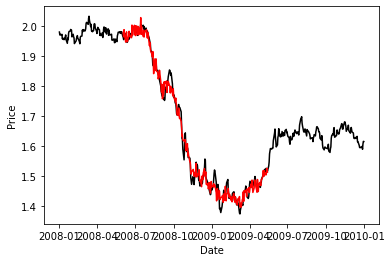

In [402]:
# visualise results by adding in a line of forecast results to the real data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# pick a date for the time series and capture that 100 elements with the DateID
fcst_date = '2008-06-01'
d = pd.to_datetime(fcst_date)
fcst = df_pred2.loc[df_pred2['Date']==d]

fcst_container = pd.DataFrame(fcst.iloc[:,0:3],columns=['DateID','Date','Close_Mid'])

                        
# reattach the date for all elements of the timeseries
                              
for e in range(1,len(fcst.iloc[:,2:].to_numpy()[0]),1):
    a = fcst.iloc[0,0] + e
    b = df_pred2.loc[df_pred2['DateID']==a]['Date'].values[0]
    c = fcst.iloc[0,e+2]
    lst = [a,b,c]
    fcst_container.loc[len(fcst_container)] = lst

results_filtered = df_norm2[(df_norm2['Year'] == 2009) + (df_norm2['Year'] == 2008)]

plt.plot(results_filtered['Date'], results_filtered['Close_Mid'], color='black')
plt.plot(fcst_container['Date'], fcst_container['Close_Mid'], color='red')
plt.ylabel('Price')
plt.xlabel('Date')